In [ ]:
# import some dependencies
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.distributions import uniform
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import seaborn as sns
import matplotlib.pyplot as plt

the visualization of uniform distribution

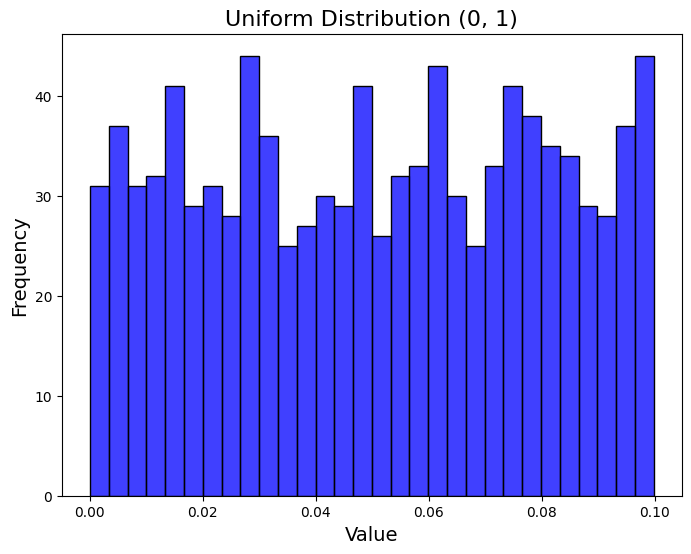

In [ ]:
import torch

distribution = uniform.Uniform(0.0, 0.1)

samples = distribution.sample((1000,))

plt.figure(figsize=(8, 6))
sns.histplot(samples.numpy(), bins=30, kde=False, color='blue')

# Add title and labels
plt.title('Uniform Distribution (0, 1)', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.show()

# Custom Batch Normalization

In [ ]:
class customBatch_Norm(nn.Module):
  def __init__(self, in_size, momentum=0.9, eps=1e-5):
    super(customBatch_Norm, self).__init__()

    self.momentum = momentum
    self.in_size = in_size
    self.eps = eps

    U = uniform.Uniform(torch.tensor([0.0]), torch.tensor([1.0]))
    self.gamma = nn.Parameter(U.sample(torch.Size([self.in_size]))).view(self.in_size)
    self.beta = nn.Parameter(torch.zeros(self.in_size))

    self.register_buffer('running_mean', torch.zeros(self.in_size))
    self.register_buffer('running_var', torch.ones(self.in_size))

    self.running_mean.zero_()
    self.running_var.fill_(1)


  def forward(self, input):

    X = input

    if len(X.shape) != 2:
      raise ValueError("only for dense layers")

    if self.training:
      mean = torch.mean(X, axis=0)
      variance = torch.mean((X - mean)**2, axis=0)

      self.running_mean = (self.momentum * self.running_mean) + (1.0 - self.momentum) * mean
      self.running_var = (self.momentum * self.running_var) + (1.0 - self.momentum) * (input.shape[0]/(input.shape[0] - 1)*variance)

    else:
      mean = self.running_mean
      variance = self.running_var

    X_hat = (X - mean) * 1.0 / torch.sqrt(variance + self.eps)   # normalize / gaussian distribution values
    out = self.gamma * X_hat + self.beta                         # scale and shifting

    return out


NN architecture example for our custom batch normalization

In [ ]:
class netnonbatch(nn.Module):
  def __init__(self):
    super(netnonbatch, self).__init__()
    self.classifier = nn.Sequential(
        nn.Linear(28 * 28, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )

  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return(x)

In [ ]:
class netbatch(nn.Module):
  def __init__(self):
    super(netbatch, self).__init__()
    self.classifier = nn.Sequential(
        nn.Linear(28 * 28, 64),
        customBatch_Norm(64),
        nn.ReLU(),
        nn.Linear(64, 128),
        customBatch_Norm(128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )

  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x


model

In [ ]:
nonBatchModel = netnonbatch()
BatchModel = netbatch()

loss and optimization

In [ ]:
loss_fc = nn.CrossEntropyLoss()
opt = optim.SGD(nonBatchModel.parameters(), lr=0.01)
opt_bn = optim.SGD(BatchModel.parameters(), lr=0.01)

load dataset

In [ ]:
train_dataset = datasets.MNIST(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_dataset = datasets.MNIST(root='dataset/', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 55.5MB/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.80MB/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.8MB/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.82MB/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [ ]:
loader = DataLoader(dataset=train_dataset, num_workers=4, batch_size=512, shuffle=True)

train

[1,   512] loss: 0.058 loss_bn: 0.057
[1, 20992] loss: 2.301 loss_bn: 2.012
[1, 41472] loss: 2.292 loss_bn: 1.647
[2,   512] loss: 0.057 loss_bn: 0.032
[2, 20992] loss: 2.268 loss_bn: 1.185
[2, 41472] loss: 2.250 loss_bn: 1.021
[3,   512] loss: 0.055 loss_bn: 0.022
[3, 20992] loss: 2.206 loss_bn: 0.808
[3, 41472] loss: 2.174 loss_bn: 0.726
[4,   512] loss: 0.053 loss_bn: 0.017
[4, 20992] loss: 2.093 loss_bn: 0.615
[4, 41472] loss: 2.034 loss_bn: 0.568
[5,   512] loss: 0.048 loss_bn: 0.013
[5, 20992] loss: 1.893 loss_bn: 0.498
[5, 41472] loss: 1.798 loss_bn: 0.476
==========Epoch 5==========


<ipython-input-54-c8f4e034dbeb>:52: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a, kde=True, color='r', label="Normal")
<ipython-input-54-c8f4e034dbeb>:57: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(b, kde=True, color='g', label="BatchNormal")


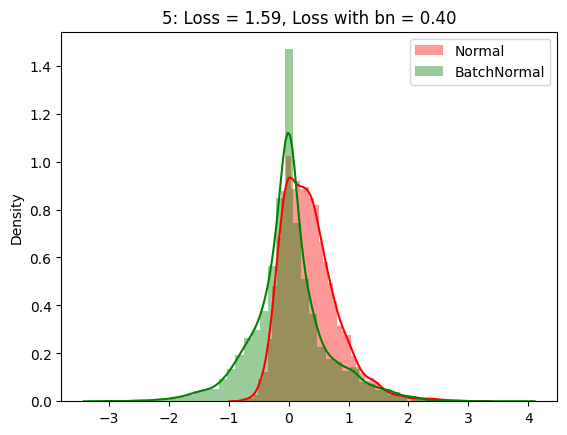

------------------------------------------------------------------


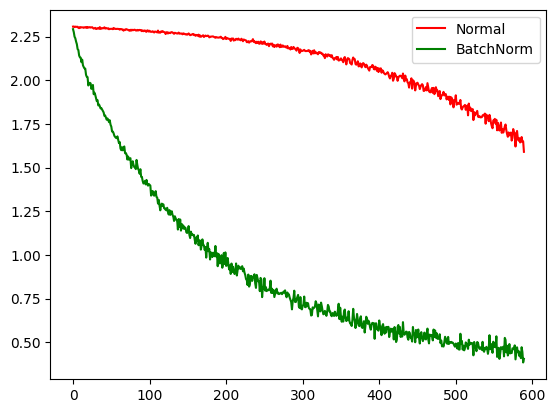

In [ ]:
loss_arr = []
loss_bn_arr = []

max_epochs = 5

for epoch in range(max_epochs):

  running_loss = 0.0
  running_loss_bn = 0.0

  for i, data in enumerate(loader, 0):

    inputs, labels = data

    # non batch normalization
    opt.zero_grad()
    output = nonBatchModel(inputs)
    loss = loss_fc(output, labels)
    loss.backward()
    opt.step()

    # batch normalization
    opt_bn.zero_grad()
    output_bn = BatchModel(inputs)
    loss_bn = loss_fc(output_bn, labels)
    loss_bn.backward()
    opt_bn.step()

    loss_arr.append(loss.item())
    loss_bn_arr.append(loss_bn.item())

    # print data
    running_loss += loss.item()
    running_loss_bn += loss_bn.item()
    if i % 40 == 0:
      print('[%d, %5d] loss: %.3f loss_bn: %.3f'%
            (epoch + 1, (i+1)*512, running_loss/40, running_loss_bn/40))
      running_loss = 0.0
      running_loss_bn = 0.0
  print("="*40)

print("="*10 + "Epoch {}".format(epoch+1) + "="*10)
inputs = inputs.view(inputs.size(0), -1)


# get Activation
nonBatchModel.eval()
BatchModel.eval()

a = nonBatchModel.classifier[0](inputs)
a = a.detach().numpy().ravel()
sns.distplot(a, kde=True, color='r', label="Normal")

b = BatchModel.classifier[0](inputs)
b = BatchModel.classifier[1](b)
b = b.detach().numpy().ravel()
sns.distplot(b, kde=True, color='g', label="BatchNormal")

plt.title('%d: Loss = %0.2f, Loss with bn = %0.2f' % (epoch+1, loss.item(), loss_bn.item()))
plt.legend()
plt.savefig('Activation-distribution.png', dpi=100)
plt.show()
plt.pause(0.5)

print("------------------------------------------------------------------")

plt.plot(loss_arr, 'r', label="Normal")
plt.plot(loss_bn_arr, 'g', label="BatchNorm")
plt.savefig("training-loss.png", dpi=100)
plt.legend()
plt.show()
